In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pydicom # working with the DICOM files
import os
import os.path
import scipy.ndimage
from skimage import measure, morphology, segmentation # image processing
import pandas as pd

In [2]:
def read_patient_data(patient_folder):
    patient_data = []
    for dcmfile in os.listdir(patient_folder):
        patient_data.append(pydicom.read_file(patient_folder + '/' + dcmfile))
        patient_data
    patient_data.sort(key = lambda slice: float(slice.ImagePositionPatient[2]))
    return patient_data
    
data_folder = 'I:/4_Sahana/DSB3/stage1/'
patients = os.listdir(data_folder)

(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.339362935321004318729883264389
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: None
(0020, 0000) Group Length                        UL: 392
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID         

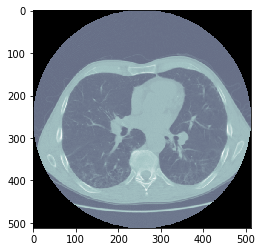

In [3]:
patient_data_sample = read_patient_data(data_folder + patients[0])
print(patient_data_sample[100]) # print out the metadata of a sample slice
plt.imshow(patient_data_sample[100].pixel_array, cmap=plt.cm.bone) # slice image
plt.show()

In [4]:
def get_hounsfield_unit_array(patient_data):
    nx = patient_data[0].Rows
    ny = patient_data[0].Columns
    nz = len(patient_data)
    hu_array = np.zeros((nx, ny, nz), dtype=np.float32)
    for slice_index in range(len(patient_data)):
        intercept = patient_data[slice_index].RescaleIntercept
        slope = patient_data[slice_index].RescaleSlope
        pixel_array = patient_data[slice_index].pixel_array
        pixel_array[pixel_array == -2000] = 0
        hu_array[:,:,slice_index] = slope * pixel_array + intercept
        
    return hu_array.astype(np.int16)

hu_array_sample = get_hounsfield_unit_array(patient_data_sample)
print('Maximum HU: {:d}, Minmum HU: {:d}'.format(np.amax(hu_array_sample), np.amin(hu_array_sample)))

Maximum HU: 3071, Minmum HU: -1024


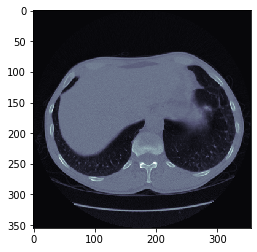

In [5]:
def resample_data(patient_data, new_spacings):
    # obtain original spacing in z-direction
    original_z_spacing = np.abs(patient_data[0].ImagePositionPatient[2]
                                - patient_data[1].ImagePositionPatient[2])
    # obtain rescaled HU array
    hu_array = get_hounsfield_unit_array(patient_data)
    
    pixel_spacing = patient_data[0].PixelSpacing
    original_spacings = np.array([float(pixel_spacing[0]), float(pixel_spacing[1]), original_z_spacing], dtype='float32')
    shape = hu_array.shape
    new_shape = np.round(hu_array.shape * original_spacings / new_spacings)
    zoom_factor = new_shape / hu_array.shape
    
    return scipy.ndimage.interpolation.zoom(hu_array, zoom_factor, mode='nearest')

new_spacings = [1, 1, 1] # unit: mm
resampled_patient_data_sample = resample_data(patient_data_sample, new_spacings)
plt.imshow(resampled_patient_data_sample[:,:,100], cmap=plt.cm.bone)
plt.show()

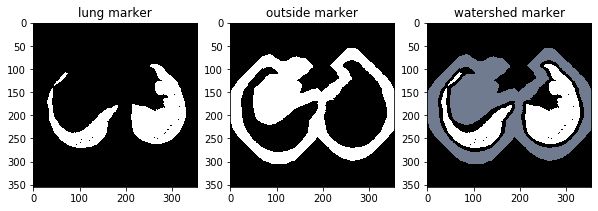

In [6]:
def create_markers(data):
    # create lung markers
    lung_marker = data < -400
    # remove the outside air
    for s in range(data.shape[2]):
        lung_marker[:,:,s] = segmentation.clear_border(lung_marker[:,:,s])
    lung_marker_labels = measure.label(lung_marker)
    potential_lung_regions = measure.regionprops(lung_marker_labels)
    potential_lung_regions.sort(key = lambda region: region.area)

    # only retain the largest regions (ideally corresponding to the lung)
    #if (len(potential_lung_regions) > 1):
    #    assert (potential_lung_regions[-1].area > 5 * potential_lung_regions[-2].area)
    for region in potential_lung_regions[:-1]:
        coords_tuple = tuple([tuple(coord) for coord in region.coords.transpose()])
        lung_marker_labels[coords_tuple] = 0
    lung_marker = lung_marker_labels > 0

    # create outside markers
    outside_marker_inbound = scipy.ndimage.binary_dilation(lung_marker, iterations=8)
    outside_marker_outbound = scipy.ndimage.binary_dilation(lung_marker, iterations=35)
    outside_marker = outside_marker_outbound ^ outside_marker_inbound
    
    # create watershed markers (lung: 2, outside: 1)
    watershed_marker = lung_marker.astype(np.int16) * 2 + outside_marker.astype(np.int16) * 1
    
    return lung_marker, outside_marker, watershed_marker

lung_marker, outside_marker, watershed_marker = create_markers(resampled_patient_data_sample)

plt.figure(figsize=(10,5))
sample_slice_index = 100
plt.subplot(131)
plt.imshow(lung_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('lung marker')
plt.subplot(132)
plt.imshow(outside_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('outside marker')
plt.subplot(133)
plt.imshow(watershed_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('watershed marker')
plt.show()

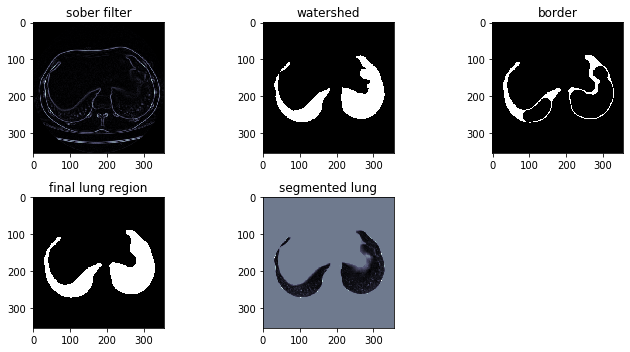

In [7]:
def slice_lung_segmentation(slice, lung_marker, watershed_marker):
    # find edges with Sober filters
    sober_x = scipy.ndimage.sobel(slice, axis=0)
    sober_y = scipy.ndimage.sobel(slice, axis=1)
    sober = np.hypot(sober_x, sober_y)

    # apply watershed algorithm to find watershed basins flooded from the markers
    watershed = morphology.watershed(sober, watershed_marker)
    
    # outline of watershed
    border = scipy.ndimage.morphological_gradient(watershed, size=(3,3)).astype(bool)
    
    # apply black tophat filter to include possible nodules near the lung border
    black_tophat = [[0, 0, 1, 1, 1, 0, 0],
                    [0, 1, 1, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [0, 1, 1, 1, 1, 1, 0],
                    [0, 0, 1, 1, 1, 0, 0]]
    black_tophat = scipy.ndimage.iterate_structure(black_tophat, 5)
    border += scipy.ndimage.black_tophat(border, structure=black_tophat)
    
    # combine the lung and the regions near its border which may contain nodules
    lung = np.bitwise_or(lung_marker, border)
    # remove the small air pockets inside the lung
    # lung = scipy.ndimage.morphology.binary_closing(lung, structure=np.ones((5,5)), iterations=4)
    lung = scipy.ndimage.binary_fill_holes(lung)
    
    return lung, sober, watershed, border

lung_marker, outside_marker, watershed_marker = create_markers(resampled_patient_data_sample)

sample_slice_index = 99
sample_slice = resampled_patient_data_sample[:,:,sample_slice_index]
lung, sober, watershed, border = slice_lung_segmentation(
    sample_slice,
    lung_marker[:,:,sample_slice_index],
    watershed_marker[:,:,sample_slice_index],
    )

plt.figure(figsize=(10,5))
plt.subplot(231)
plt.imshow(sober, cmap=plt.cm.bone)
plt.title('sober filter')
plt.subplot(232)
plt.imshow(watershed, cmap=plt.cm.bone)
plt.title('watershed')
plt.subplot(233)
plt.imshow(border, cmap=plt.cm.bone)
plt.title('border')
plt.subplot(234)
plt.imshow(lung, cmap=plt.cm.bone)
plt.title('final lung region')
plt.subplot(235)
segmented_slice = np.ones(sample_slice.shape) * 30
segmented_slice[lung] = sample_slice[lung]
plt.imshow(segmented_slice, cmap=plt.cm.bone)
plt.title('segmented lung')

plt.tight_layout()
plt.show()

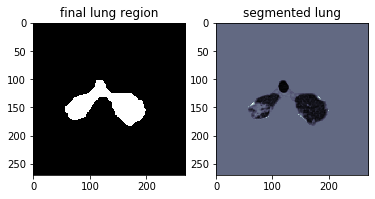

In [8]:
patient_data_sample2 = read_patient_data(data_folder + '5572cc61f851b0d10d6fec913ae722b9')
resampled_patient_data_sample2 = resample_data(patient_data_sample2, new_spacings)
lung_marker, outside_marker, watershed_marker = create_markers(resampled_patient_data_sample2)

sample_slice_index2 = -24
sample_slice2 = resampled_patient_data_sample2[:,:,sample_slice_index2]
lung, sober, watershed, border = slice_lung_segmentation(
    sample_slice2,
    lung_marker[:,:,sample_slice_index2],
    watershed_marker[:,:,sample_slice_index2],
    )
segmented_slice2 = np.ones(sample_slice2.shape) * 30
segmented_slice2[lung] = sample_slice2[lung]

plt.figure()
plt.subplot(121)
plt.imshow(lung, cmap=plt.cm.bone)
plt.title('final lung region')
plt.subplot(122)
plt.imshow(segmented_slice2, cmap=plt.cm.bone)
plt.title('segmented lung')
plt.show()

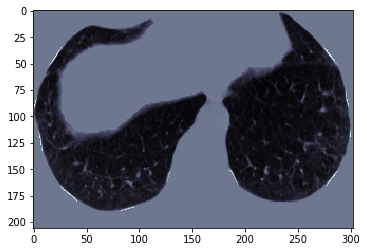

In [9]:
def lung_segmentation(data):
    # set HU outside the lung region to 30 (similar to the tissue HU around the lung)
    segmented_lung = np.ones(data.shape) * 30
    segmented_lung_marker = np.zeros(data.shape)
    
    lung_marker, outside_marker, watershed_marker = create_markers(data)
    
    for slice_index in range(data.shape[2]):
        slice_marker,_,_,_ = slice_lung_segmentation(data[:,:,slice_index],
                                                     lung_marker[:,:,slice_index],
                                                     watershed_marker[:,:,slice_index])
        segmented_lung_marker[:,:,slice_index] = slice_marker
    segmented_lung[segmented_lung_marker.astype(bool)] = data[segmented_lung_marker.astype(bool)]

    # crop the blank borders
    for x_begin in range(data.shape[0]):
        slice = segmented_lung_marker[x_begin,:,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for x_end in range(-1,-data.shape[0]-1,-1):
        slice = segmented_lung_marker[x_end,:,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for y_begin in range(data.shape[1]):
        slice = segmented_lung_marker[:,y_begin,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for y_end in range(-1,-data.shape[1]-1,-1):
        slice = segmented_lung_marker[:,y_end,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for z_begin in range(data.shape[2]):
        slice = segmented_lung_marker[:,:,z_begin]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for z_end in range(-1,-data.shape[2]-1,-1):
        slice = segmented_lung_marker[:,:,z_end]
        if not np.array_equal(slice, np.zeros(slice.shape)): break

    if x_end == -1: x_end = -2
    if y_end == -1: y_end = -2
    if z_end == -1: z_end = -2

    return segmented_lung[x_begin:(x_end+1),y_begin:(y_end+1),z_begin:(z_end+1)]

segmented_lung_sample = lung_segmentation(resampled_patient_data_sample)
plt.imshow(segmented_lung_sample[:,:,63], cmap=plt.cm.bone)
plt.show()

In [10]:
def reshape_data(segmented_lung, desired_shape):
    shape = list(segmented_lung.shape)
    diff = np.array(desired_shape) - np.array(shape)
    pad_width = []
    for i in range(3):
        before = (abs(diff[i])/2).astype(np.int16)
        after = abs(diff[i]) - before
        # make sure the size is not larger than the desired size
        # if (i != 2): assert (diff[i] >= 0), \
        #    "shape %s is larger than desired shape %s for axis %s" % (shape[i], desired_shape[i], i)
        if diff[i] >= 0:
            pad_width.append((before, after))
        else:
            pad_width.append((0,0))
            # trim the array when the actual size is greater than the desrized size
            if i == 0: segmented_lung = segmented_lung[before:(-after),:,:]
            if i == 1: segmented_lung = segmented_lung[:,before:(-after),:]
            # trim the bottom part since studies show that lung nodules are less likely to
            # be cancerous in bottom and middle lobes
            if i == 2: segmented_lung = segmented_lung[:,:,abs(diff[i]):]
                
            print('Data trimmed for axis ' + str(i))

    # pad constant values when the actual size is less than the desired size
    reshaped_data = np.lib.pad(segmented_lung, tuple(pad_width), 'constant', constant_values=30)
    assert (list(reshaped_data.shape) == desired_shape), \
        'data shape is (%s, %s, %s) but desired shape is (%s, %s, %s)' \
        % (reshaped_data.shape[0], reshaped_data.shape[1], reshaped_data.shape[2], \
        desired_shape[0], desired_shape[1], desired_shape[2])
    
    return reshaped_data

desired_shape = [250, 350, 400]
reshaped_sample = reshape_data(segmented_lung_sample, desired_shape)

In [11]:
def normalize_data(reshaped_data, min_hu, max_hu):
    normalized_data = (reshaped_data - min_hu) / (max_hu - min_hu)
    normalized_data[normalized_data < 0.] = 0.
    normalized_data[normalized_data > 1.] = 1.
    return normalized_data
    
min_hounsfield_unit = -1000.
max_hounsfield_unit = 400.

normalized_sample = normalize_data(reshaped_sample,
                                   min_hounsfield_unit,
                                   max_hounsfield_unit)

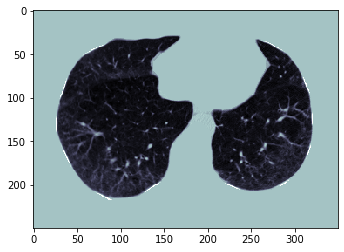

In [12]:
def zero_centering(data, mean):
    return data - mean

mean = 0.3
preprocessed_sample = zero_centering(normalized_sample, mean)
plt.imshow(preprocessed_sample[:,:,114], cmap=plt.cm.bone)
plt.show()

In [13]:
labels = pd.read_csv('stage1_labels.csv')
labels[:10]

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1
5,0092c13f9e00a3717fdc940641f00015,0
6,00986bebc45e12038ef0ce3e9962b51a,0
7,00cba091fa4ad62cc3200a657aeb957e,0
8,00edff4f51a893d80dae2d42a7f45ad1,1
9,0121c2845f2b7df060945b072b2515d7,0


In [14]:
# folder for saving preprocessed data
save_data_folder = 'I:/4_Sahana/sample_images_preprocessed/'

for patient in patients:
    if (os.path.exists(save_data_folder + patient + '.npz')):
        print('Patient: ' + patient + ' (data existed)')
        continue
    patient_data = read_patient_data(data_folder + patient)
    resampled_patient_data = resample_data(patient_data, new_spacings)
    segmented_lung = lung_segmentation(resampled_patient_data)
    reshaped_patient_data = reshape_data(segmented_lung, desired_shape)
    normalized_patient_data = normalize_data(reshaped_patient_data,
                                      min_hounsfield_unit,
                                      max_hounsfield_unit)
    preprocessed_patient_data = zero_centering(normalized_patient_data, mean)
    
    # read label
    patient_label = labels[labels['id'] == patient]
    
    # save preprocessed data to a .npz file
    if patient_label.shape[0] == 1: # training set
        np.savez_compressed(save_data_folder + patient,
                            id = patient,
                            data = preprocessed_patient_data,
                            label = patient_label.iloc[0,1],
                            set = 'training')
    else: # test set
        np.savez_compressed(save_data_folder + patient,
                            id = patient,
                            data = preprocessed_patient_data,
                            set = 'test')    
    
    # print out the shape information
    print('Patient: ' + patient)
    print('Resampled shape: ({:3d},{:3d},{:3d}) \
        Segmented shape: ({:3d},{:3d},{:3d}) \
        Final shape: ({:3d},{:3d},{:3d})'.format(
        resampled_patient_data.shape[0],
        resampled_patient_data.shape[1],
        resampled_patient_data.shape[2],
        segmented_lung.shape[0],
        segmented_lung.shape[1],
        segmented_lung.shape[2],
        preprocessed_patient_data.shape[0],
        preprocessed_patient_data.shape[1],
        preprocessed_patient_data.shape[2],))
print('Preprocessing is done!')

Patient: 0015ceb851d7251b8f399e39779d1e7d (data existed)
Patient: 0030a160d58723ff36d73f41b170ec21 (data existed)
Patient: 003f41c78e6acfa92430a057ac0b306e (data existed)
Patient: 006b96310a37b36cccb2ab48d10b49a3 (data existed)
Patient: 008464bb8521d09a42985dd8add3d0d2 (data existed)
Patient: 0092c13f9e00a3717fdc940641f00015 (data existed)
Patient: 00986bebc45e12038ef0ce3e9962b51a (data existed)
Patient: 00cba091fa4ad62cc3200a657aeb957e (data existed)
Patient: 00edff4f51a893d80dae2d42a7f45ad1 (data existed)
Patient: 0121c2845f2b7df060945b072b2515d7 (data existed)
Patient: 013395589c01aa01f8df81d80fb0e2b8 (data existed)
Patient: 01de8323fa065a8963533c4a86f2f6c1 (data existed)
Patient: 01e349d34c06410e1da273add27be25c (data existed)
Patient: 01f1140c8e951e2a921b61c9a7e782c2 (data existed)
Patient: 024efb7a1e67dc820eb61cbdaa090166 (data existed)
Patient: 0257df465d9e4150adef13303433ff1e (data existed)
Patient: 026470d51482c93efc18b9803159c960 (data existed)
Patient: 0268f3a7a17412178cfb03

Patient: 666becc9794c25bb8e0e7982be7cb6dc (data existed)
Patient: 666fad0dca00694381eeec67adc909ec (data existed)
Patient: 6675d3cc20585f44d4c45746cb1002d4 (data existed)
Patient: 668bb968918c63fad7d65581825b1048 (data existed)
Patient: 66a92d789e440d3dbef3c69d20e20694 (data existed)
Patient: 66a94647459dd5a13f4336e1421119c5 (data existed)
Patient: 66b7666912e1d469cd9817a1cade694c (data existed)
Patient: 66cef72d8428dbba31f2ab01abdaf6ca (data existed)
Patient: 66fb40934f0be4b301fe27db7fb62299 (data existed)
Patient: 673ee14e01a0628b45c78500d402056e (data existed)
Patient: 676467220abd8e2104417c5213664ef9 (data existed)
Patient: 678c5ec1360784e0fe797208069e0bbb (data existed)
Patient: 6799964c08ad5ce7740defcd3bd037a6 (data existed)
Patient: 67ccc2ecd7716e1cab05caaedea99f4b (data existed)
Patient: 67e87fa621f2e3e838b1b17a898d5b41 (data existed)
Patient: 67f7f74220c08faa756b34cb81b203a5 (data existed)
Patient: 6828335aec9aa0d0053ec0949319aa4b (data existed)
Patient: 6857c76be618bb0ddced5f

Patient: b8dc33b670bb078d10954345c3ffbb3a
Resampled shape: (320,320,315)         Segmented shape: (211,277,288)         Final shape: (250,350,400)
Patient: b921bb8f821ccab27ab69ea94b8149a7
Resampled shape: (290,290,300)         Segmented shape: (213,245,239)         Final shape: (250,350,400)
Patient: b947a27711c94dda2d13e7410285cc0c
Resampled shape: (370,370,336)         Segmented shape: (202,305,258)         Final shape: (250,350,400)
Patient: b997943f8b95d72ca9a3c36f5c695412
Resampled shape: (360,360,328)         Segmented shape: (200,309,327)         Final shape: (250,350,400)
Patient: ba05599872742ce748e2eda745e51857
Resampled shape: (360,360,308)         Segmented shape: (193,289,307)         Final shape: (250,350,400)
Patient: ba162711fc958842582ef1828d37f8e0
Resampled shape: (380,380,331)         Segmented shape: (205,297,260)         Final shape: (250,350,400)
Patient: ba71b330a16e8b4c852f9a8730ee33b9
Resampled shape: (350,350,351)         Segmented shape: (222,308,308)       

Patient: c0c5a155e6e59588783c2964975e7e1e
Resampled shape: (290,290,344)         Segmented shape: (184,289,310)         Final shape: (250,350,400)
Patient: c0f0eb84e70b19544943bed0ea6bd374
Resampled shape: (350,350,292)         Segmented shape: (231,289,274)         Final shape: (250,350,400)
Patient: c0f2e3b499d10d147892579d0ad71321
Resampled shape: (312,312,348)         Segmented shape: (203,311,338)         Final shape: (250,350,400)
Patient: c14816a1a9a6852c6b0d88fe5585c8bb
Resampled shape: (326,326,306)         Segmented shape: (180,279,279)         Final shape: (250,350,400)
Patient: c1673993c070080c1d65aca6799c66f8
Resampled shape: (319,319,320)         Segmented shape: (171,262,272)         Final shape: (250,350,400)
Patient: c187d7be84f64e29e6623c15575f373f
Resampled shape: (302,302,308)         Segmented shape: (195,301,275)         Final shape: (250,350,400)
Patient: c19197af81f94110ddc23317e182f37d
Resampled shape: (340,340,290)         Segmented shape: (215,311,276)       

Patient: c87a713d17522698958de55c97654beb
Resampled shape: (253,253,313)         Segmented shape: (200,252,275)         Final shape: (250,350,400)
Patient: c8a82a4e7e76702f5f10ece6508f2bbe
Resampled shape: (350,350,305)         Segmented shape: (209,303,281)         Final shape: (250,350,400)
Patient: c8cfb917b0d619cb4e25f789db4641f8
Resampled shape: (340,340,328)         Segmented shape: (199,297,315)         Final shape: (250,350,400)
Patient: c928b4fee44ea322ac65348ae2ff20b8
Resampled shape: (290,290,362)         Segmented shape: (192,289,335)         Final shape: (250,350,400)
Patient: c95f2aa23e6d6702f5b16a3b35f89cf0
Resampled shape: (310,310,328)         Segmented shape: (182,291,287)         Final shape: (250,350,400)
Patient: c979fbec565e769de7e66944ab5365a4
Resampled shape: (340,340,348)         Segmented shape: (205,291,314)         Final shape: (250,350,400)
Patient: c98675ecb5bdc7eb35c69d730da05df1
Resampled shape: (280,280,295)         Segmented shape: (176,245,278)       

Patient: d2282b0eb61b8d3b090cf8eb76776529
Resampled shape: (317,317,345)         Segmented shape: (196,268,326)         Final shape: (250,350,400)
Patient: d2285c33945ab3421d753b4fc59ac3ce
Resampled shape: (360,360,318)         Segmented shape: (208,288,303)         Final shape: (250,350,400)
Patient: d244870d213a21efa86e86c951d8c9a2
Resampled shape: (271,271,328)         Segmented shape: (190,270,306)         Final shape: (250,350,400)
Patient: d287819450e57ae8c883ed31dc4dc3a3
Resampled shape: (320,320,268)         Segmented shape: (184,298,257)         Final shape: (250,350,400)
Patient: d2a17180c72ce7e5e9cb3870ba7991d2
Resampled shape: (350,350,376)         Segmented shape: (205,303,319)         Final shape: (250,350,400)
Patient: d2b47d9034d38a410f00dabba9754d91
Resampled shape: (290,290,298)         Segmented shape: (162,267,285)         Final shape: (250,350,400)
Patient: d2ec8f0fc56a9168cda0c707e49974ab
Resampled shape: (263,263,314)         Segmented shape: (179,262,311)       

Data trimmed for axis 0
Patient: da8fea00d3e921e5d8ab4d90a7f6002f
Resampled shape: (360,360,294)         Segmented shape: (252,300,284)         Final shape: (250,350,400)
Patient: daaf7680aa9a2b519e53b0e38300163d
Resampled shape: (320,320,300)         Segmented shape: (170,264,283)         Final shape: (250,350,400)
Patient: daee58dd09c005fe41ca370c2a2fdfa9
Resampled shape: (360,360,335)         Segmented shape: (233,308,306)         Final shape: (250,350,400)
Patient: db7c113445db32f9beaf5dc90e7218ad
Resampled shape: (330,330,308)         Segmented shape: (188,294,286)         Final shape: (250,350,400)
Patient: dbcb3dbee4f4e75d0672c2a23feb1e3a
Resampled shape: (331,331,294)         Segmented shape: (228,313,278)         Final shape: (250,350,400)
Patient: dbd9c8025907511e965e7abad955547d
Resampled shape: (360,360,344)         Segmented shape: (224,317,300)         Final shape: (250,350,400)
Patient: dbfbc12c7a943a2dc0e34bfd4a636bca
Resampled shape: (320,320,281)         Segmented sha

Patient: e43afa905c8e279f818b2d5104f6762b
Resampled shape: (340,340,356)         Segmented shape: (222,321,355)         Final shape: (250,350,400)
Patient: e4421d2d5318845c1cccbc6fa308a96e
Resampled shape: (310,310,298)         Segmented shape: (224,309,273)         Final shape: (250,350,400)
Patient: e4436b5914162ff7efea2bdfb71c19ae
Resampled shape: (348,348,332)         Segmented shape: (192,295,310)         Final shape: (250,350,400)
Patient: e46973b13a7a6f421430d81fc1dda970
Resampled shape: (400,400,324)         Segmented shape: (225,331,310)         Final shape: (250,350,400)
Patient: e4a87107f94e4a8e32b735d18cef1137
Resampled shape: (298,298,326)         Segmented shape: (196,297,295)         Final shape: (250,350,400)
Data trimmed for axis 0
Patient: e4ff18b33b7110a64f497e177102f23d
Resampled shape: (340,340,310)         Segmented shape: (260,291,277)         Final shape: (250,350,400)
Patient: e537c91cdfa97d20a39df7ef04a52570
Resampled shape: (377,377,342)         Segmented sha

Patient: ed83b655a1bbad40a782ad13cf27ce8f
Resampled shape: (323,323,318)         Segmented shape: (223,322,313)         Final shape: (250,350,400)
Patient: eda58f4918c4b506cd156702bf8a56a3
Resampled shape: (290,290,368)         Segmented shape: (171,257,351)         Final shape: (250,350,400)
Patient: edad1a7e85b5443e0ae9e654d2adbcba
Resampled shape: (290,290,316)         Segmented shape: (201,289,271)         Final shape: (250,350,400)
Patient: edae2e1edd1217d0c9e20eff2a7b2dd8
Resampled shape: (300,300,264)         Segmented shape: (193,262,263)         Final shape: (250,350,400)
Data trimmed for axis 0
Patient: edbf53a8478049de1494b213fdf942e6
Resampled shape: (360,360,302)         Segmented shape: (255,301,286)         Final shape: (250,350,400)
Patient: ee71210fa398cbb080f6c537a503e806
Resampled shape: (280,280,304)         Segmented shape: (199,258,278)         Final shape: (250,350,400)
Patient: ee88217bee233a3bfc971b450e3d8b85
Resampled shape: (375,375,268)         Segmented sha

Patient: f5630f467acd9aa977b61a3e5780c2eb
Resampled shape: (306,306,324)         Segmented shape: (176,272,303)         Final shape: (250,350,400)
Patient: f5713e8c98ef5378ea678fb8d9192e13
Resampled shape: (350,350,328)         Segmented shape: (226,349,316)         Final shape: (250,350,400)
Patient: f5717f7cbc08d8bd942cd4c1128e3339
Resampled shape: (344,344,280)         Segmented shape: (227,343,279)         Final shape: (250,350,400)
Patient: f599c9bb0bd19126e13fba8b63d2de41
Resampled shape: (399,399,320)         Segmented shape: (208,305,271)         Final shape: (250,350,400)
Patient: f5ff7734997820b45dafa75dff60ece8
Resampled shape: (290,290,304)         Segmented shape: (197,252,277)         Final shape: (250,350,400)
Patient: f63f2f63e2619012b4c798fd638c8b8a
Resampled shape: (342,342,330)         Segmented shape: (229,291,305)         Final shape: (250,350,400)
Patient: f69c80f898c9dfd8d3595b7ca7b8c66c
Resampled shape: (276,276,320)         Segmented shape: (147,233,281)       

Patient: fda187bfb1d6a2ecd4abd862c7f7f94c
Resampled shape: (280,280,312)         Segmented shape: (165,279,292)         Final shape: (250,350,400)
Patient: fdcd385b0d2d12341661e1abe845be0b
Resampled shape: (341,341,362)         Segmented shape: (197,296,294)         Final shape: (250,350,400)
Patient: fdf2a2f5b86aea0da54732056fc7ab48
Resampled shape: (340,340,318)         Segmented shape: (203,304,301)         Final shape: (250,350,400)
Patient: fdf73dcce35167f3ed952a58f5a6f738
Resampled shape: (346,346,290)         Segmented shape: (215,310,285)         Final shape: (250,350,400)
Patient: fe26fd2bb25112b3c2ca93eb8e34f8ed
Resampled shape: (310,310,316)         Segmented shape: (201,293,307)         Final shape: (250,350,400)
Patient: fe45462987bacc32dbc7126119999392
Resampled shape: (321,321,302)         Segmented shape: (230,320,289)         Final shape: (250,350,400)
Patient: fe5c37e82b412833b8ad0abb57978377
Resampled shape: (290,290,270)         Segmented shape: (199,252,255)       

In [3]:
preprocessed_data_folder = 'I:/4_Sahana/sample_images_preprocessed/'

data_shape = [250, 350, 400]
train_size = 0.8 # relative size of train set
batch_size = 5 # divide set into batches to prevent machine from running out of memory

In [1]:

%matplotlib inline

import tensorflow as tf
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
def one_hot_encode(labels):
    one_hot = np.zeros((len(labels), 2))
    one_hot[np.arange(len(labels)), labels] = 1
    
    return one_hot

sample_labels = [1, 0, 1]
one_hot_sample_labels = one_hot_encode(sample_labels)
print(one_hot_sample_labels)

[[0. 1.]
 [1. 0.]
 [0. 1.]]


In [32]:
patients = os.listdir(preprocessed_data_folder)
shuffle(patients) # randomize the order of data



In [33]:
# initialization
train_batches = []
valid_batches = []
current_train_batch = []
current_valid_batch = []

train_data_size = 0
valid_data_size = 0

for i in range(len(patients[:1200])):  
    if patients[i].startswith('.'): continue # ignore hidden files
    #patient_data = 
    if np.load(preprocessed_data_folder + patients[i])['set'] == 'test': continue # ignore test data
    
    if i < int(len(patients[:1200]) * train_size): # train set
        current_train_batch.append(patients[i])
        
        #  if current train batch is full
        if (len(current_train_batch) == batch_size): 
            train_batches.append(current_train_batch)
            train_data_size += batch_size
            current_train_batch = []
            
    else: # validation set
        current_valid_batch.append(patients[i])
        
        #  if current validation batch is full
        if (len(current_valid_batch) == batch_size): 
            valid_batches.append(current_valid_batch)
            valid_data_size += batch_size
            current_valid_batch = []

# save the remaining training and validation data set
if len(current_train_batch) != 0:
    train_data_size += len(current_train_batch)
    # pad zeros to make its size equal to batch_size
    while (len(current_train_batch) != batch_size):
        current_train_batch.append(0)
    train_batches.append(current_train_batch)
    current_train_batch = []

if len(current_valid_batch) != 0:
    valid_data_size += len(current_valid_batch)
    while (len(current_valid_batch) != batch_size):
        current_valid_batch.append(0)
    valid_batches.append(current_valid_batch)
    current_valid_batch = []

train_batches = np.array(train_batches)
valid_batches = np.array(valid_batches)

print('Total data size: {:d}, Training data size: {:d}, Validation data size: {:d} '.format(
    train_data_size + valid_data_size, train_data_size, valid_data_size))
print('Number of train batches: {:d}, Number of validation batches: {:d}'.format(
    train_batches.shape[0], valid_batches.shape[0]))

Total data size: 1200, Training data size: 960, Validation data size: 240 
Number of train batches: 192, Number of validation batches: 48


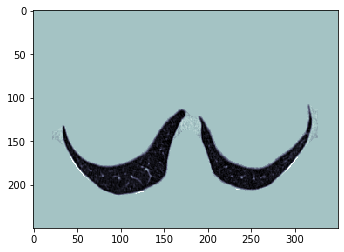

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [34]:
def read_batch(batch_files):
    
    # do not account the placeholder zeros for the batch size
    current_batch_size = batch_size - np.sum(batch_files == '0')
    
    batch_features = np.zeros((current_batch_size, data_shape[0], data_shape[1], data_shape[2], 1))
    
    labels = []
    for i in range(len(batch_files)):
        if batch_files[i] != '0':
            data = np.load(preprocessed_data_folder + batch_files[i])
            batch_features[i,:,:,:,0] = data['data']
            labels.append(data['label'])
    
    # one-hot encoding
    batch_labels = one_hot_encode(labels)

    return batch_features, batch_labels

train_features_batch_sample, train_labels_batch_sample = read_batch(train_batches[0])

plt.imshow(train_features_batch_sample[0,:,:,100,0], cmap=plt.cm.bone)
plt.show()
print(train_labels_batch_sample)

In [36]:
def conv3d(tensor, n_outputs, ksize, stride):
    # tensor: input tensor to the layer
    # n_outputs: number of outputs for convolutional layer
    # ksize: kernel size for convolutional layer
    # stride: stride size for convolutional layer
    
    # weight and bias tensor for convolutional layer
    weight = tf.Variable(tf.truncated_normal([ksize,
                                              ksize,
                                              ksize,
                                              tensor.get_shape().as_list()[4],
                                              n_outputs],
                                              stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # convolutional layer
    tensor = tf.nn.conv3d(tensor,
                          weight,
                          strides = [1,stride,stride,stride,1],
                          padding = 'SAME')
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

In [38]:
def maxpool(tensor, ksize, stride):
    # tensor: input tensor to the layer
    # ksize: kernel size for max-pooling layer
    # stride: stride size for max-pooling layer
    
    # max-pooling layer
    tensor = tf.nn.max_pool3d(tensor,
                              ksize = [1,ksize,ksize,ksize,1],
                              strides = [1,stride,stride,stride,1],
                              padding = 'SAME')
    
    return tensor

In [39]:
def flatten(tensor):
    flattened_size = np.prod(tensor.get_shape().as_list()[1:])
    return tf.reshape(tensor, [-1, flattened_size])

In [40]:
def fully_conn(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the fully-connected layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the fully-connected layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    # activation layer
    tensor = tf.nn.relu(tensor)
    
    return tensor

In [41]:
def output(tensor, n_outputs):
    # tensor: input 2D tensor to the layer
    # n_outputs: number of outputs of the output layer
    
    size = tensor.get_shape().as_list()[1]
    
    # weigth and bias tensor for the output layer
    weight = tf.Variable(tf.truncated_normal([size, n_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # output layer
    tensor = tf.matmul(tensor, weight)
    tensor = tf.nn.bias_add(tensor, bias)
    
    return tensor

In [42]:
def conv_net(x, keep_prob):
    # x: placeholder tensor that holds the input
    # keep_prob: placeholder tensor for the dropout layer
    
    # convolutional and max-pooling layers
    x = maxpool(x, 2, 2) # applying a max-pooling layer first to reduce the memory usage
    
    conv1 = conv3d(x, 32, 5, 2)
    conv1 = maxpool(conv1, 2, 2)
    
    conv2 = conv3d(conv1, 64, 5, 2)
    conv2 = maxpool(conv2, 2, 2)

    conv3 = conv3d(conv2, 128, 5, 2)
    conv3 = maxpool(conv3, 2, 2)
    
    # flatten layer
    flat = flatten(conv3)
    
    # fully-connected layers
    fc1 = fully_conn(flat, 1024)
    fc2 = fully_conn(fc1, 256)
    fc3 = fully_conn(fc2, 64)
    
    # dropout layer
    dropout = tf.nn.dropout(fc3, keep_prob)
    
    # output layer
    y = output(dropout, 2)
    
    return y

In [43]:
tf.reset_default_graph()

# inputs
x = tf.placeholder(tf.float32, (None, data_shape[0], data_shape[1], data_shape[2], 1), name='x')
y = tf.placeholder(tf.float32, (None, 2), name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# convolutional neural network model
logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits') # name logits tensor

# cost function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
optimizer = tf.train.AdamOptimizer().minimize(cost) # Adam gradient descent optimizer

# accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Exception ignored in: <function NpzFile.__del__ at 0x000002126EE150D8>
Traceback (most recent call last):
  File "C:\Users\sahana\anaconda3\lib\site-packages\numpy\lib\npyio.py", line 226, in __del__
    self.close()
  File "C:\Users\sahana\anaconda3\lib\site-packages\numpy\lib\npyio.py", line 217, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
Exception ignored in: <function NpzFile.__del__ at 0x000002126EE150D8>
Traceback (most recent call last):
  File "C:\Users\sahana\anaconda3\lib\site-packages\numpy\lib\npyio.py", line 226, in __del__
    self.close()
  File "C:\Users\sahana\anaconda3\lib\site-packages\numpy\lib\npyio.py", line 217, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
Exception ignored in: <function NpzFile.__del__ at 0x000002126EE150D8>
Traceback (most recent call last):
  File "C:\Users\sahana\anaconda3\lib\site-packages\numpy\lib\npyio.py", line 226, in __del__
    self.clo

In [44]:
def train_conv_net(session, optimizer, keep_probability, features_batch, labels_batch):
    session.run(optimizer, feed_dict={
        x: features_batch,
        y: labels_batch,
        keep_prob: keep_probability
    })

def stats(session, function, n_batch, set):
    # n_batch: number of batches used for  calculation
    if set == 'train':
        assert (n_batch <= train_batches.shape[0])
        batches = train_batches
    if set == 'valid':
        assert (n_batch <= valid_batches.shape[0])
        batches = valid_batches
    
    
    batch_indices = np.arange(batches.shape[0])
    shuffle(batch_indices) # randomize the order
    batch_indices = batch_indices[:n_batch] # only select the first n_batch batches
    
    total_stats = 0.
    total_size = 0.
    # loop over the selected set
    for batch_index in batch_indices:
        features, labels = read_batch(batches[batch_index])
        current_stats = session.run(function, feed_dict={
                                    x: features,
                                    y: labels,
                                    keep_prob: 1. # deactivate dropout layer
                                    })
        current_batch_size = batch_size - np.sum(batches[batch_index] == '0')
        total_stats += current_stats * current_batch_size
        total_size += current_batch_size
    
    return total_stats / total_size
    
        
        
# print out current training stats
def show_stats(session, cost, accuracy):
    # training loss
    loss = stats(session, cost, 200, 'train')
    
    # validation loss
    valid_loss = stats(session, cost, 50, 'valid')
    
    # validation accuracy
    valid_accuracy = stats(session, accuracy, 50, 'valid')
    
    print('Training Loss: {:>8.4f} Validation Loss: {:>8.4f} Validation Accuracy: {:.6f}'.format(
        loss, valid_loss, valid_accuracy))

In [45]:
# hyperparameters
epochs = 4
keep_probability = 0.7
model_save_path = 'I:/4_Sahana/model1'

In [46]:
# start training
with tf.Session() as sess:
    # initialization
    sess.run(tf.global_variables_initializer())
    
    # saver
    saver = tf.train.Saver()
    
    # training
    for epoch in range(epochs):
        # loop over training batches
        for batch_index in range(train_batches.shape[0]):
            features_batch, labels_batch = read_batch(train_batches[batch_index])
            train_conv_net(sess, optimizer, keep_probability, features_batch, labels_batch)
            print('Epoch {:>2}, Batch {:>3} '.format(epoch + 1, batch_index), end='\r')
        print('Epoch {:>2} '.format(epoch + 1), end='')
        show_stats(sess, cost, accuracy)
        # save model
        saver.save(sess, model_save_path + '_' + str(epoch))

KeyboardInterrupt: 